In [ ]:
import requests
from bs4 import BeautifulSoup
import re

headers = {
    'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.169 Safari/537.36'
}

member_list_300 = []
for index in range(1,31):
    url = f'https://www.assembly.go.kr/portal/cnts/cntsNaas/findNaasThx01.json?pageIndex={index}'
    print(url)
    res = requests.get(url, headers=headers)
    #print(res.status_code)
    if res.ok:
        #print(res.json()['resultList'])
        member_list_10 = []
        for member in res.json()['resultList']:
            member_list_10.append(member) 
        
        #print(member_list_10)
        member_list_300.extend(member_list_10)
    else:
        print(res.status_code)
print(len(member_list_300))
print(member_list_300[:3])

In [2]:
from pprint import pprint

pprint(member_list_300[:3])

[{'cmitNm': '교육위원회',
  'electGbnNm': '비례대표',
  'hgNm': '강경숙',
  'mImgUrl': '/static/portal/img/openassm/new/68f83caf0c9e4546b1694ead863f45ce.jpg',
  'mLinkUrl': '/members/22nd/KANGKYUNGSOOK',
  'mThumbImgUrl': '/static/portal/img/openassm/new/thumb/68f83caf0c9e4546b1694ead863f45ce.jpg',
  'monaCd': 'T2T8225E',
  'openNaId': 'KANGKYUNGSOOK',
  'origNm': '비례대표',
  'polyNm': '조국혁신당',
  'reeleGbnNm': '초선',
  'rnum': 1,
  'sexGbnNm': '여',
  'st': '22',
  'unitNm': '제22대'},
 {'cmitNm': '국방위원회',
  'electGbnNm': '지역구',
  'hgNm': '강대식',
  'mImgUrl': '/static/portal/img/openassm/new/d1fe9f0902d84f0ba74f721d3298be7f.png',
  'mLinkUrl': '/members/22nd/KANGDAESIK',
  'mThumbImgUrl': '/static/portal/img/openassm/new/thumb/d1fe9f0902d84f0ba74f721d3298be7f.png',
  'monaCd': 'L2I9861C',
  'openNaId': 'KANGDAESIK',
  'origNm': '대구 동구군위군을',
  'polyNm': '국민의힘',
  'reeleGbnNm': '재선',
  'rnum': 2,
  'sexGbnNm': '남',
  'st': '22',
  'unitNm': '제22대'},
 {'cmitNm': '환경노동위원회, 기후위기 특별위원회',
  'electGbnNm': '지역구',

#### Json 데이터와 상세페이지 스크래핑 데이터 를 혼합해서 상세정보 저장하기

In [ ]:
import requests
from bs4 import BeautifulSoup
import re
from urllib.parse import urljoin

print('===> 스크래핑 시작')
#297명의 정보를 저장하는 List
member_detail_list = []

headers = {
    'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.169 Safari/537.36'
}

for idx,member in enumerate(member_list_300,1):
    mem_sub_link = member['mLinkUrl']
    detail_url = f'https://www.assembly.go.kr{mem_sub_link}'
    res = requests.get(detail_url, headers=headers)
    print(res.ok, idx, detail_url)
    
    if res.ok:
        soup = BeautifulSoup(res.text, 'html.parser')
        
        #1명의 정보를 저장하는 dict 선언
        member_detail_dict = {}
        
        li_tags = soup.select('ul.list li:nth-of-type(n+4)')
        #print(li_tags)
        # for li in li_tags:
        #     print(type(li.find('dt')))
        #     print(li.find('dt').text)
        
        dt_list = [li_tag.find('dt').text for li_tag in li_tags]
        #print(dt_list)

        dd_list = []        
        for li_tag in li_tags:
            dd_tag = li_tag.find('dd')
            pattern = re.compile(f'[\n\r\t]')
            dd_text = pattern.sub('',dd_tag.text.strip()).replace(" ","")
            dd_list.append(dd_text)
        #print(dd_list)
        
        member_detail_dict = dict(zip(dt_list, dd_list))

        member_detail_dict['이름'] = member['hgNm']        
        member_detail_dict['정당'] = member['polyNm']
        member_detail_dict['성별'] = member['sexGbnNm']
        member_detail_dict['선거구'] = member['origNm']
        member_detail_dict['지역비례'] = member['electGbnNm']

        sosok = member['cmitNm']
        if sosok is not None:
            idx = sosok.find(',')
            if idx > -1:            
                member_detail_dict['소속위원회'] = sosok[:idx]
            else:
                member_detail_dict['소속위원회'] = sosok
        else:        
            member_detail_dict['소속위원회'] = ''    

        # print(member_detail_dict['소속위원회'])                        
        
        member_detail_dict['당선횟수'] = member['reeleGbnNm']
        
        img_sub_url = member['mThumbImgUrl']
        img_url = urljoin(detail_url,img_sub_url)
        #print(img_url)
        member_detail_dict['이미지'] = img_url
        
        #pprint(member_detail_dict)        
                        
        #1명의 정보가 저장된 dict를 list에 추가하기
        member_detail_list.append(member_detail_dict)
    else:
        print(res.status_code)
        
print(len(member_detail_list))
print(member_detail_list[297:])
print('===> 스크래핑 끝')

#### 웹스크래핑한 데이터를 Pandas DataFrame객체로 저장하여 분석 및 시각화

In [ ]:
import pandas as pd

member_df = pd.DataFrame(columns=['이름','정당','선거구','당선횟수','지역비례','성별','소속위원회','이미지','사무실 전화','사무실 호실',\
                                  '개별 홈페이지','이메일','보좌관','선임비서관','비서관','의원실 안내'])

for member_detail in member_detail_list:
    # Row 하나 생성
    df_new_row = pd.DataFrame.from_records([member_detail])
    member_df = pd.concat([member_df, df_new_row])
    # dict <=> Series
    #series_obj = pd.Series(member_detail)
    # Series 객체를 append 
    #member_df = member_df.append(series_obj, ignore_index=True)

print(member_df.columns)
print(member_df.shape)    
member_df.head(2)

In [9]:
# index가 1부터 시작하도록 재설정
member_df.reset_index(drop=True, inplace=True)
member_df.index = member_df.index + 1
print(member_df.index)

RangeIndex(start=1, stop=299, step=1)


In [ ]:

member_df['정당'].unique()

In [13]:
member_df['정당'].value_counts()

정당
더불어민주당    167
국민의힘      107
조국혁신당      12
진보당         4
무소속         3
개혁신당        3
기본소득당       1
사회민주당       1
Name: count, dtype: int64

In [ ]:
member_df['당선횟수'].value_counts()

당선횟수
초선    131
재선     79
3선     46
4선     24
5선     14
6선      4
Name: count, dtype: int64

In [ ]:
member_df.loc[member_df['당선횟수'] == '6선']

In [20]:
member_df['성별'].value_counts(normalize=True)

성별
남    0.791946
여    0.208054
Name: proportion, dtype: float64

In [ ]:
member_df['선거구'].value_counts()

In [24]:
#선거구2 컬럼을 새로 추가
#경남 창원시성산구 -> 경남
print(type(member_df['선거구']))
print(type(member_df['선거구'].str))
#Series객체를 StringMethods 객체로 변환(문자열 슬라이싱을 하기 위해서)
temp_str = member_df['선거구'].str
#2글자 슬라이싱 값을 선거구2 라는 컬럼으로 저장
member_df['선거구2'] = temp_str[:2]

member_df.loc[0:3,['선거구','선거구2']]

<class 'pandas.core.series.Series'>
<class 'pandas.core.strings.accessor.StringMethods'>


,선거구,선거구2
1,비례대표,비례
2,대구 동구군위군을,대구
3,경기 안양시만안구,경기


In [ ]:
member_df['선거구2'].value_counts()

In [ ]:
# Row Counting - normalize=True 속성은 % (퍼센티지) 비율로 나타냄
member_df['선거구2'].value_counts(normalize=True)

In [ ]:
member_df['지역비례'].value_counts()

In [ ]:
member_df['지역비례'].value_counts(normalize=True)

In [31]:
member_df['이미지'].tail()

294    https://www.assembly.go.kr/static/portal/img/o...
295    https://www.assembly.go.kr/static/portal/img/o...
296    https://www.assembly.go.kr/static/portal/img/o...
297    https://www.assembly.go.kr/static/portal/img/o...
298    https://www.assembly.go.kr/static/portal/img/o...
Name: 이미지, dtype: object

### 시각화
* Image 출력 - Image 객체, diplay() 함수 사용
* seaborn - countplot, distplot, heatmap Plot 그려보기
* maplotlib - histogram, pie  Plot 그려보기
* 한글폰트 설정

In [33]:
%matplotlib inline

In [35]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import seaborn as sns

In [36]:

#한글폰트 설정
font_path = 'C:\\Windows\\Fonts\\malgun.ttf'
# font의 파일정보로 font name을 알아내기
font_prop = fm.FontProperties(fname=font_path).get_name()
print(font_prop)
# matplotlib의 rc(run command) 함수를 사용해서 폰트이름 설정
matplotlib.rc('font', family=font_prop)

Malgun Gothic


### Seaborn 의 막대 그래프
* barplot - x축과 y축을 둘 다 설정할 수 있음
* countplot - x축 이나 y축 중에서 하나만 설정할 수 있음
    * 범주형 속성을 가지는 데이터들의 히스토그램을 보여준다.
    * 종류별로 count를 보여주는 Plot이다.

In [ ]:
member_df['정당'].value_counts().index

In [ ]:
figure, (axes1,axes2,axes3) = plt.subplots(nrows=3, ncols=1)
figure.set_size_inches(18,12)

sns.countplot(data=member_df, x='정당', ax=axes1, order=member_df['정당'].value_counts().index, hue='정당')
sns.countplot(data=member_df, x='당선횟수', ax=axes2, order=member_df['당선횟수'].value_counts().index, hue='당선횟수')
sns.countplot(data=member_df, x='성별', ax=axes3, order=member_df['성별'].value_counts().index, hue='성별')

plt.show()

#### Matplotlib 의 Pie Plot 그려보기

In [45]:
cdf = member_df['선거구2'].value_counts(normalize=True)
print(cdf.index)
cdf

Index(['경기', '서울', '비례', '부산', '경남', '경북', '인천', '대구', '전북', '충남', '전남', '충북',
       '광주', '강원', '대전', '울산', '제주', '세종'],
      dtype='object', name='선거구2')


선거구2
경기    0.201342
서울    0.161074
비례    0.154362
부산    0.060403
경남    0.053691
경북    0.043624
인천    0.043624
대구    0.040268
전북    0.033557
충남    0.033557
전남    0.033557
충북    0.026846
광주    0.026846
강원    0.026846
대전    0.023490
울산    0.020134
제주    0.010067
세종    0.006711
Name: proportion, dtype: float64

In [ ]:
# figure size 설정
figure = plt.figure(figsize=(20,12))
print(type(figure))
# pie() 함수 - pie plot을 그려주는 함수
plt.pie(cdf, labels=cdf.index, autopct='%1.1f%%', startangle=140, shadow=True)
# pie plot을 그릴때 원의 형태를 유지하도록 하는 설정
plt.axis('equal')
plt.title('선거구 분포값')
plt.show()

#### Seaborn의 HistPlot (분포도)
* 히스토그램은 구간에 따른 Count를 표현하기 때문에, y는 count로 고정되어 있어 x값만 설정하면 됩니다. ( x 와 y 중에서 하나만 설정하면 됩니다.)
* hue 옵션은 값에 따라 Plot의 색을 다르게 표현할 수 있다.
* multiple = 'dodge'|'stack'

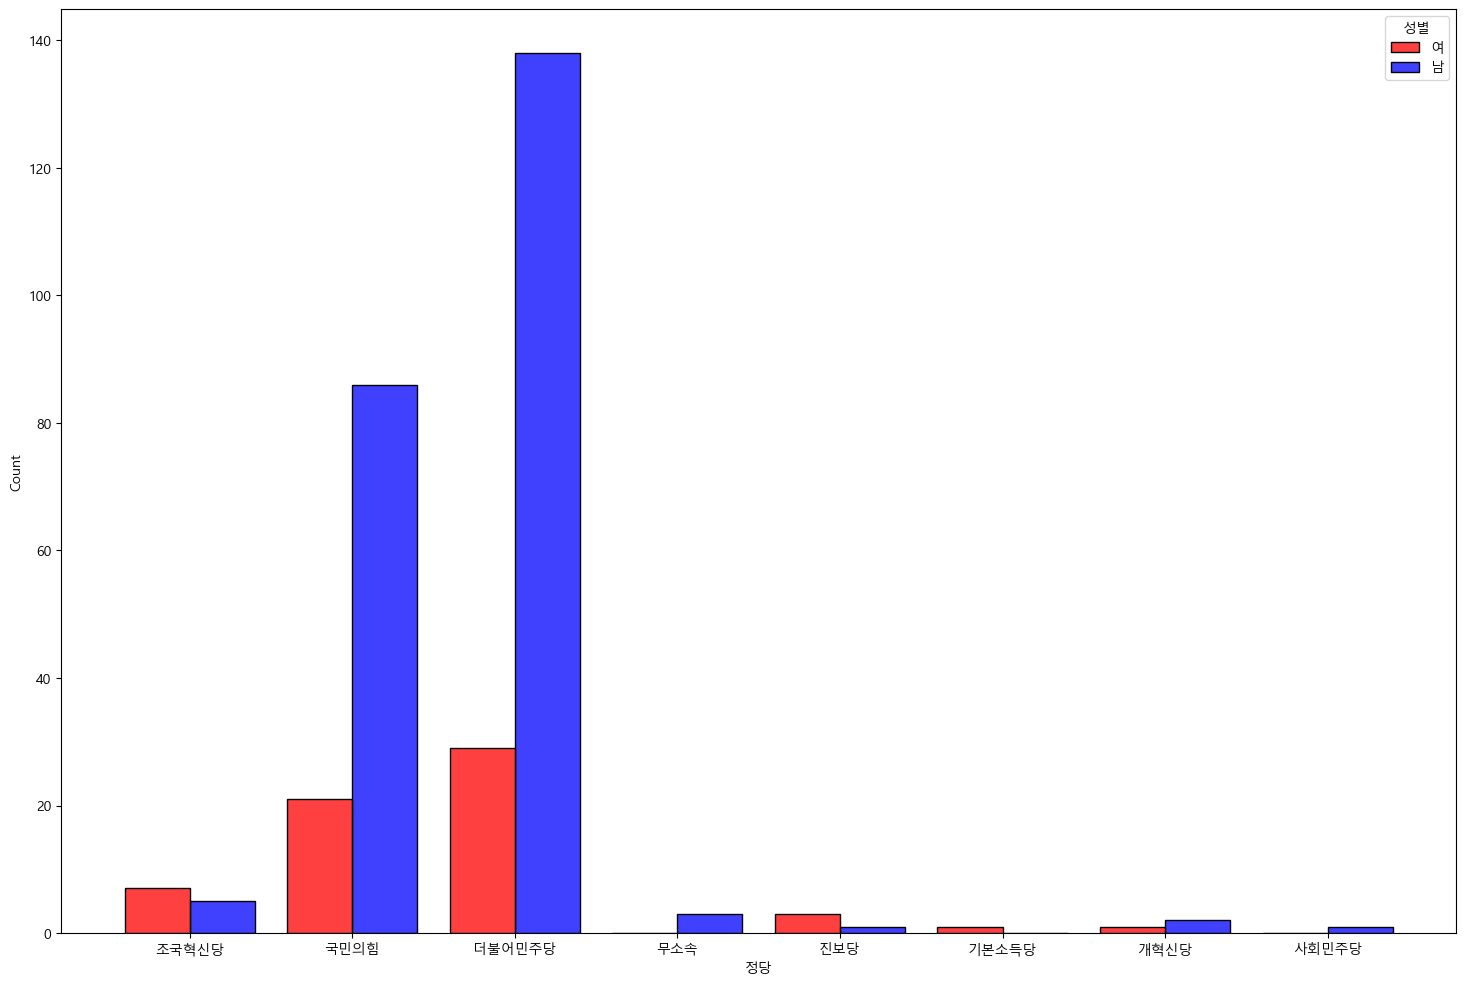

In [57]:
figure, axes1 = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(18,12)

_ = sns.histplot(data=member_df, x='정당', ax=axes1, hue='성별', multiple='dodge',
             palette={'남': 'blue', '여': 'red'}, shrink=0.8)
plt.show()

In [63]:
member_df.loc[member_df['정당'] == '조국혁신당',['이름','성별']].groupby('성별').count()

,이름
성별,
남,5
여,7
